# Fake news detection

A fake news are those stories that are false, manupulated, no solid proof or not from reliable sources.

Dataset: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import tree
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# download necessary resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Read datasets

In [58]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

## Data cleaning and preparation

In [59]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [60]:
data.head(5)

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [61]:
data.tail(5)

,title,text,subject,date,target
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",true
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",true
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",true
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",true
44897,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",true


In [62]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [63]:
data.head()

,title,text,subject,date,target
0,IS THIS THE TERRORIST WHO INSPIRED DALLAS COP ...,Who is this terrorist and why has not yet been...,politics,"Jul 8, 2016",fake
1,WOW! BREAKING NEWS: Proof Obama LIED To Press…...,The most transparent administration in histor...,politics,"Nov 3, 2016",fake
2,Illinois governor urges 2018 vote on 'rigged' ...,CHICAGO (Reuters) - Illinois Republican Govern...,politicsNews,"August 26, 2016",true
3,Twitter TEARS Paul Ryan To BLOODY RIBBONS For...,The Congressional Budget Office s review of th...,News,"March 13, 2017",fake
4,‘Unable To Sleep’ NFL Quarterback Regrets Not ...,The man who won two Super Bowls for the city o...,politics,"Sep 25, 2017",fake


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [65]:
# Removing the date and title
data.drop(["date"],axis=1,inplace=True)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Who is this terrorist and why has not yet been...,politics,fake
1,The most transparent administration in histor...,politics,fake
2,CHICAGO (Reuters) - Illinois Republican Govern...,politicsNews,true
3,The Congressional Budget Office s review of th...,News,fake
4,The man who won two Super Bowls for the city o...,politics,fake


In [66]:
# define a function to clean the text
def clean_text(text):
    # remove punctuations and numbers
    cleaned_text = ''.join(e for e in text if e.isalpha() or e.isspace())
    # convert to lowercase
    cleaned_text = cleaned_text.lower()
    # tokenize the text into words
    words = word_tokenize(cleaned_text)
    # remove stopwords
    stopword = stopwords.words('english')
    words = [word for word in words if word not in stopword]
    # stem the remaining words
    # stemmer = PorterStemmer()
    # words = [stemmer.stem(word) for word in words]
    # join the stemmed words back into a string
    cleaned_text = ' '.join(words)
    # print(cleaned_text)
    return cleaned_text

# Clean data
data = data.dropna()
data["text"] = data["text"].apply(clean_text)

## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


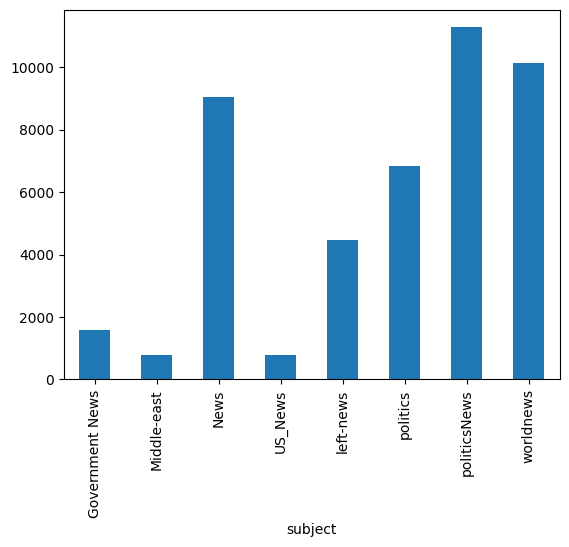

In [67]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


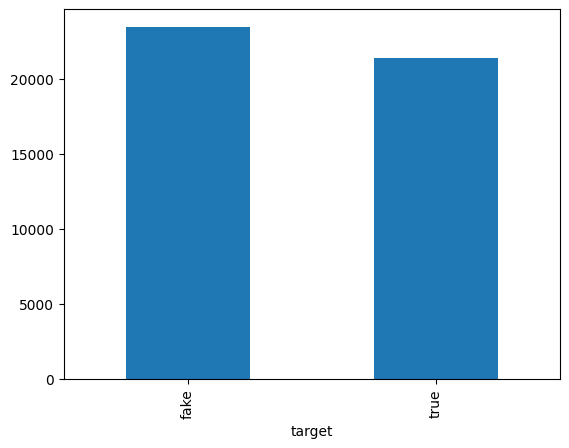

In [68]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [69]:
# Most frequent words counter   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

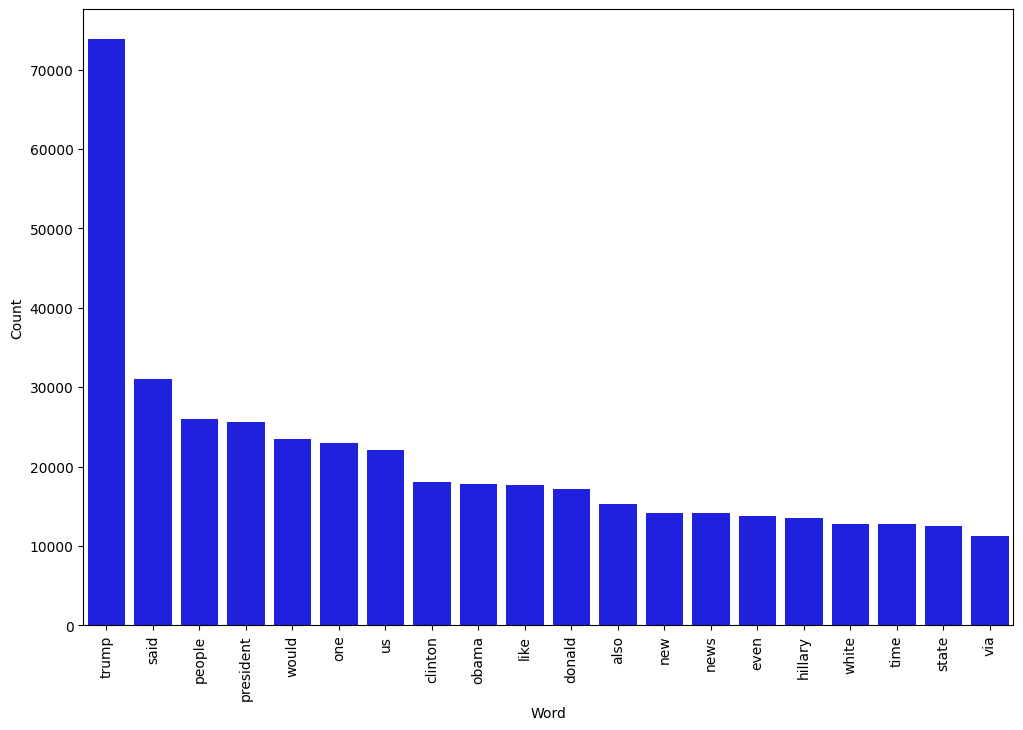

In [70]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

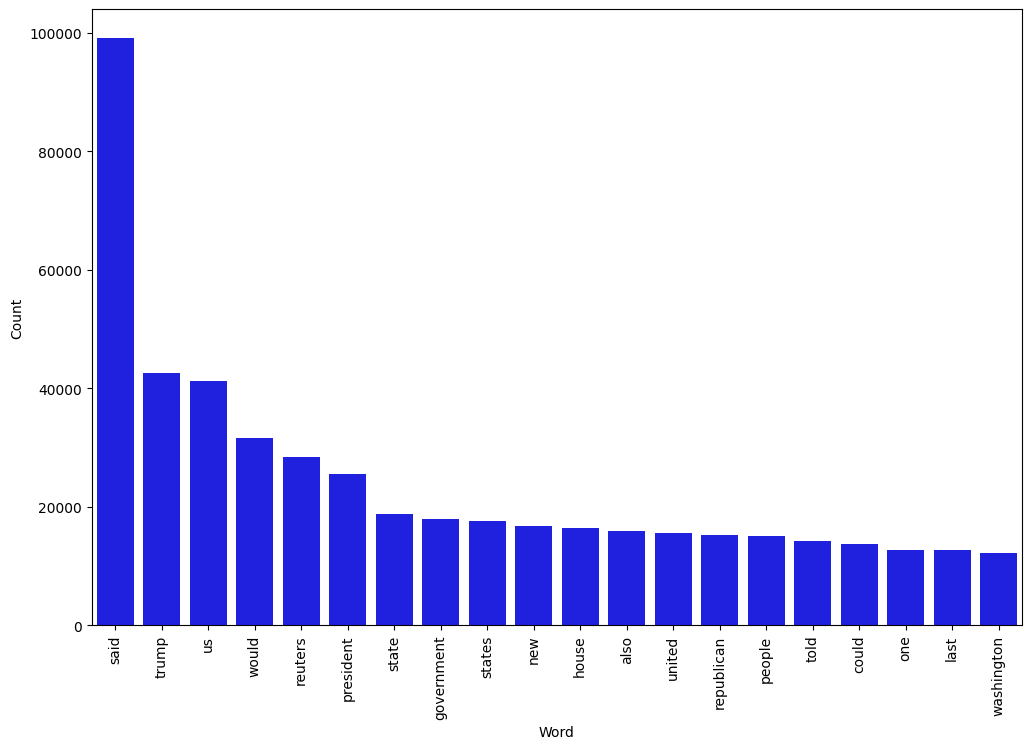

In [71]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [72]:
# Function to plot the confusion matrix
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Split Data

In [73]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [74]:
X_train.head()

36335    united nations reuters former us national secu...
12384    washington reuters president barack obama unve...
24419    washington reuters president donald trump said...
24740                                                     
27039    washington reuters republican donald trump thr...
Name: text, dtype: object

In [75]:
y_train.head()

36335    true
12384    true
24419    true
24740    fake
27039    true
Name: target, dtype: object

### Decision Tree Classifier

In [76]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.73%


In [99]:
# Predict probabilities for each class
proba = model.predict_proba([X_test.values[3]])

# Predict labels for test set
prediction = model.predict([X_test.values[3]])

# Display predicted class labels along with predicted probabilities
for i, class_label in enumerate(model.classes_):
    print("Class '{}' - Probability = {:.2f}%".format(class_label, proba[0][i]*100))
print("Predicted class = {}".format(prediction[0]))


Class 'fake' - Probability = 100.00%
Class 'true' - Probability = 0.00%
Predicted class = fake


Confusion matrix, without normalization


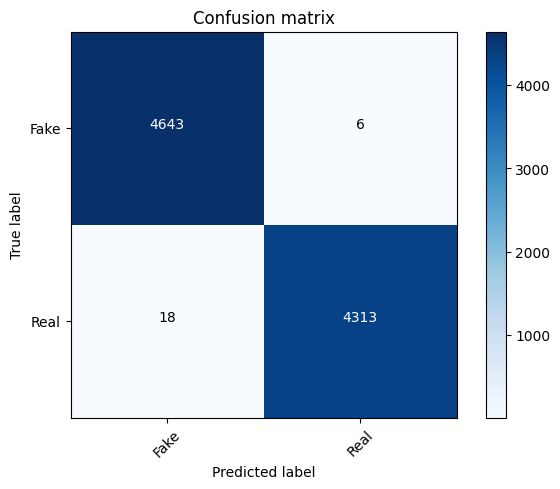

In [77]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

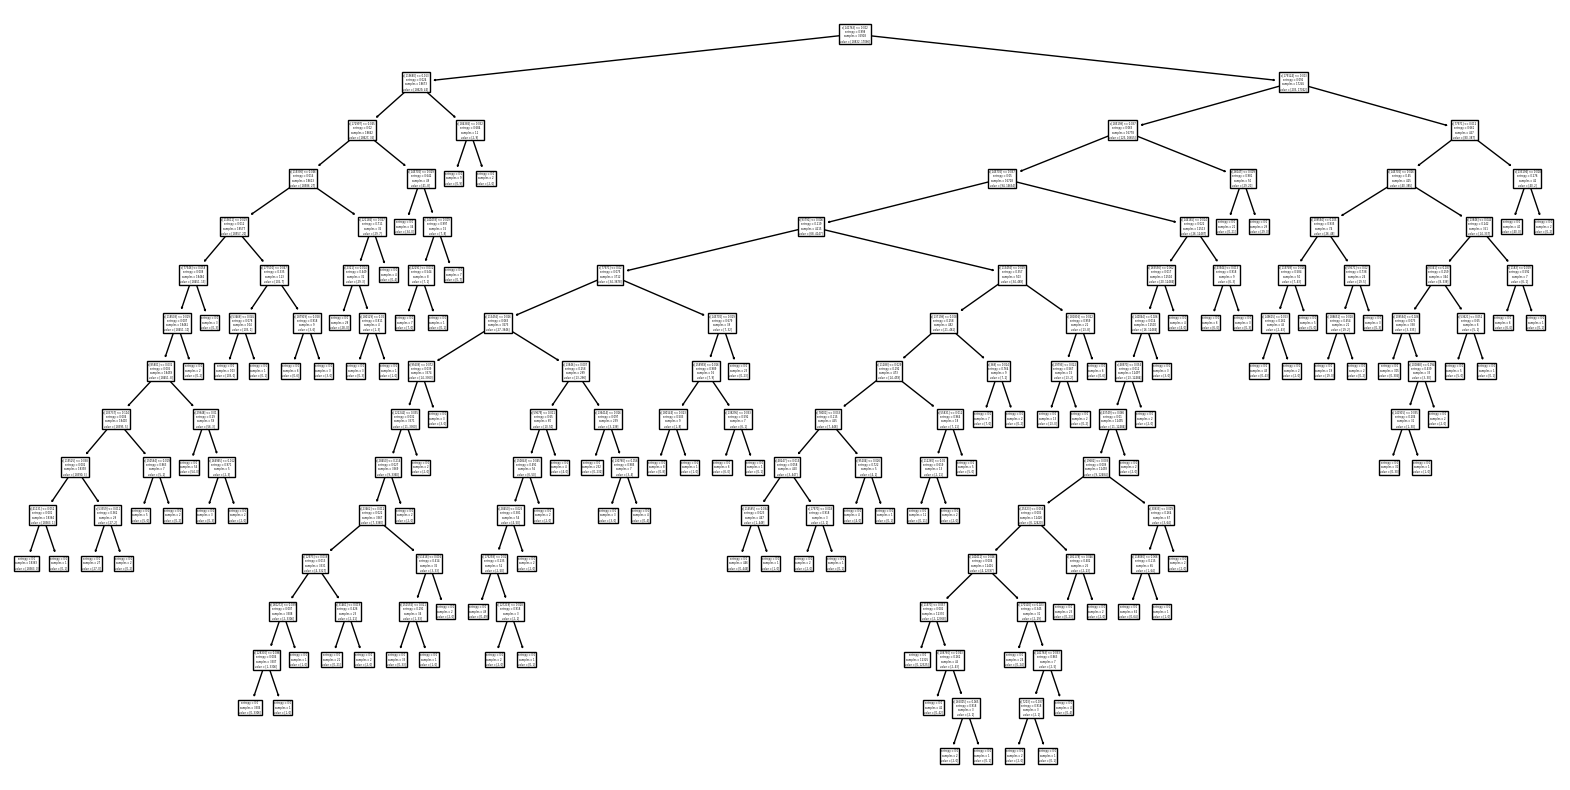

In [81]:
# Extract the decision tree from the pipeline
tree_model = model.named_steps['model']

# Visualize the decision tree
fig, ax = plt.subplots(figsize=(20, 10))
tree.plot_tree(tree_model, ax=ax)
plt.show()